In [ ]:
# default_exp datasets.bases.session

# Session Datasets
> Implementation of session dataset modules.

In [ ]:
#export
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from recohut.visualization.basic_plots import BasicVisual

from tqdm import tqdm
from abc import *
from pathlib import Path
import os.path as osp
from collections.abc import Sequence
import sys
import tempfile
import shutil
import pickle
import time
import csv
import math
import operator
import itertools
from collections import defaultdict
import datetime
from datetime import date, timezone, timedelta
from pandas import Timedelta

import torch

from recohut.datasets.bases.common import Dataset
from recohut.utils.common_utils import *

In [ ]:
#exporti
class ItemPopularityPlot(BasicVisual):
    def __init__(self, item_counts, **kwargs):
        self.item_counts = item_counts
        super().__init__(**kwargs)

    def plot(self):
        self.ax = plt.semilogy(sorted(self.item_counts))

In [ ]:
#exporti
class SessionLengthPlot(BasicVisual):
    def __init__(self, session_lengths, **kwargs):
        self.session_lengths = session_lengths
        super().__init__(**kwargs)

    def plot(self):
        sns.boxplot(x=self.session_lengths, ax=self.ax)
        for patch in self.ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .7))

In [ ]:
#export
class SessionData:
    def __init__(self, df, session_col='SESSIONID', item_col='ITEMID', *args, **kwargs):
        self.df = df
        self.session_col = session_col
        self.item_col = item_col
        self.df.dropna(inplace=True)
    
    def filter_short_sessions(self, min_session_length: int = 3):
        item_counts = self.df.groupby([self.session_col]).count()[self.item_col]
        self.df = self.df[self.df[self.session_col].isin(item_counts[item_counts >= min_session_length].index)].reset_index(drop=True)

    def get_session_sequences(self):
        """
        Construct a list of lists
    
        Example:
            Given a df that looks like 
            SessionID |   ItemID 
            ----------------------
                1     |     111
                1     |     123
                1     |     345
                2     |     045 
                2     |     334
                2     |     342
                2     |     8970
                2     |     345
            
            Retrun a list of lists like this: 
            sessions = [
                    ['111', '123', '345'],
                    ['045', '334', '342', '8970', '345'],
            ]
        """
        grp_by_session = self.df.groupby([self.session_col])
        session_sequences = []
        for name, group in grp_by_session:
            session_sequences.append(list(group[self.item_col].values))
        return session_sequences

    def get_split_next_event_prediction(self, session_sequences = None, test_size: int = 10000):
        """
        Next Event Prediction (NEP) does not necessarily follow the traditional train/test split. 
        Instead training is perform on the first n-1 items in a session sequence of n items. 
        The test set is constructed of (n-1, n) "query" pairs where the n-1 item is used to generate 
        recommendation predictions and it is checked whether the nth item is included in those recommendations. 
        Example:
            Given a session sequence ['045', '334', '342', '8970', '128']
            Training is done on ['045', '334', '342', '8970']
            Testing (and validation) is done on ['8970', '128']
        
        Test and Validation sets are constructed to be disjoint. 
        """
        if session_sequences is None:
            session_sequences = self.get_session_sequences()
        ## Construct training set
        # use (1 st, ..., n-1 th) items from each session sequence to form the train set (drop last item)
        train = [sess[:-1] for sess in session_sequences]

        if test_size > len(train):
            print(
                f"Test set cannot be larger than train set. Train set contains {len(train)} sessions."
            )
            return

        ### Construct test and validation sets
        # sub-sample 10k sessions, and use (n-1 th, n th) pairs of items from session_squences to form the
        # disjoint validaton and test sets
        test_validation = [sess[-2:] for sess in session_sequences]
        index = np.random.choice(range(len(test_validation)), test_size * 2, replace=False)
        test = np.array(test_validation)[index[:test_size]].tolist()
        validation = np.array(test_validation)[index[test_size:]].tolist()

        return train, test, validation

    def get_item_counts(self):
        return self.df.groupby([self.item_col]).count()[self.session_col].values

    def get_session_lengths(self):
        return self.df.groupby(self.session_col).count()[self.item_col].values
    
    def plot_item_popularity(self):
        kwargs = {'label_x':'Item index', 'label_y':'Item counts', 
                  'figsize':(7,4), 'title':'Items Popularity Plot'}
        _ = ItemPopularityPlot(self.get_item_counts(), **kwargs)
    
    def plot_session_length(self):
        kwargs = {'label_x':'Session length (# of items)', 'label_y':'', 
                  'figsize':(7,4), 'title':'Session Length Plot'}
        _ = SessionLengthPlot(self.get_session_lengths(), **kwargs)

    def info(self):
        session_lengths = self.get_session_lengths()
        basic_stats = ["Minimum session length: \t{}".format(min(session_lengths))]
        basic_stats.append("Maximum session length: \t{}".format(max(session_lengths)))
        basic_stats.append("Mean session length: \t \t{}".format(np.mean(session_lengths).round(2)))
        basic_stats.append("Median session length: \t \t{}".format(int(np.median(session_lengths))))
        basic_stats.append("Total number of purchases: \t{}".format(np.sum(session_lengths)))
        basic_stats = '\n'.join(basic_stats)
        print(basic_stats)

Example

In [ ]:
!wget -O data.zip https://github.com/RecoHut-Datasets/retail_session/raw/v1/onlineretail.zip
!unzip data.zip

In [ ]:
df = pd.read_csv('OnlineRetail.csv', encoding="ISO-8859-1", parse_dates=["InvoiceDate"])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
ds = SessionData(df, session_col='CustomerID', item_col='StockCode')

In [ ]:
ds.info()

Minimum session length: 	1
Maximum session length: 	7983
Mean session length: 	 	93.05
Median session length: 	 	42
Total number of purchases: 	406829


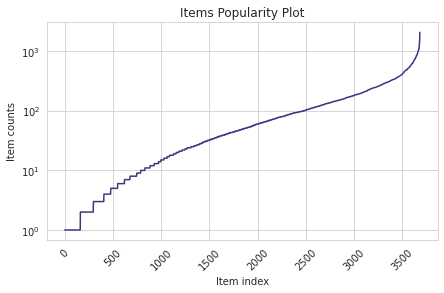

In [ ]:
ds.plot_item_popularity()

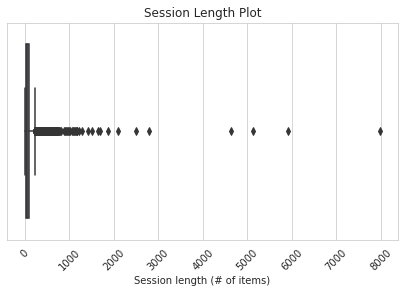

In [ ]:
ds.plot_session_length()

In [ ]:
ds.filter_short_sessions(min_session_length=5)

In [ ]:
ds.info()

Minimum session length: 	5
Maximum session length: 	7983
Mean session length: 	 	98.46
Median session length: 	 	45
Total number of purchases: 	406253


In [ ]:
train, val, test = ds.get_split_next_event_prediction(test_size=1000)

In [ ]:
len(train), len(val), len(test)

(4126, 1000, 1000)

## Session Dataset

In [ ]:
#export
class SessionDataset(Dataset):
    r"""Session data base class.

    Args:
        min_session_length (int): Minimum number of items for a session to be valid
        min_item_support (int): Minimum number of interactions for an item to be valid
        eval_sec (int): these many seconds from the end will be taken as validation data

    References:
        1. https://github.com/Ethan-Yys/GRU4REC-pytorch-master/blob/master/preprocessing.py
    """
    def __init__(self,
                 root,
                 min_session_length: int = None,
                 min_item_support: int = None,
                 eval_sec: int = 86400,  # valid/test data is one day = 86400 seconds
                 ):
        super().__init__(root)
        self.min_session_length = min_session_length
        self.min_item_support = min_item_support
        self.eval_sec = eval_sec

        self._process()

    def load_ratings_df(self):
        r"""load raw dataset into pandas dataframe"""
        raise NotImplementedError

    def remove_short_sessions(self, df):
        r"""delete sessions where session length is less than `min_session_length`"""
        # groupby session id and get size of each session
        session_len = df.groupby('uid').size()
        df = df[np.in1d(df.uid, session_len[session_len >= self.min_session_length].index)]
        return df

    def remove_sparse_items(self, df):
        r"""delete records of items which appeared less than `min_item_support` times"""
        # groupby itemID and get size of each item
        item_len = df.groupby('sid').size()
        df = df[np.in1d(df.sid, item_len[item_len >= self.min_item_support].index)]
        # remove sessions of less than n interactions again
        df = self.remove_short_sessions(df)
        return df

    def split_df(self, df):
        timeMax = df.timestamp.max() #maximum time in all records
        sessionMaxTime = df.groupby('uid').timestamp.max() #group by uid and get the maximum time of each session
        sessionTrain = sessionMaxTime[sessionMaxTime < (timeMax - self.eval_sec)].index #training split is all sessions that ended before the `eval_sec` seconds
        sessionTest  = sessionMaxTime[sessionMaxTime >= (timeMax - self.eval_sec)].index #testing split is all sessions has records in the `eval_sec` seconds
        train = df[np.in1d(df.uid, sessionTrain)]
        test = df[np.in1d(df.uid, sessionTest)]
        # Delete records in testing split where items are not in training split
        test = test[np.in1d(test.sid, train.sid)]
        # Delete Sessions in testing split
        test = self.remove_short_sessions(test)
        print('Training Set has {} Events, {} Sessions, and {} Items\n\n'.format(
            len(train), train.uid.nunique(), train.sid.nunique()))
        print('Validation Set has {} Events, {} Sessions, and {} Items\n\n'.format(
            len(test), test.uid.nunique(), test.sid.nunique()))
        return train, test

Examples

In [ ]:
class YoochooseDataset(SessionDataset):
    data_id = '1UEcKC4EfgMVD2n_zBvAyp0vRNyv7ndSF'

    def __init__(self,
                 root,
                 min_session_length: int = 2,
                 min_item_support: int = 5,
                 eval_sec: int = 86400,
                 ):
        super().__init__(root, min_session_length, min_item_support, eval_sec)

    @property
    def raw_file_names(self) -> str:
        return 'rsc15-clicks.dat'

    @property
    def processed_file_names(self) -> str:
        return ['yoochoose_train.txt','yoochoose_valid.txt']

    def download(self):
        from google_drive_downloader import GoogleDriveDownloader as gdd
        from shutil import move, rmtree

        path = osp.join(self.raw_dir, 'rsc15.zip')
        gdd.download_file_from_google_drive(self.data_id, path)
        extract_zip(path, self.raw_dir)
        move(osp.join(self.raw_dir, 'rsc15', 'raw', ),
             osp.join(self.raw_dir, self.raw_file_names))
        rmtree(osp.join(self.raw_dir, 'rsc15'))
        os.unlink(path)

    def process(self):
        df = self.load_ratings_df()
        if self.min_session_length is not None:
            df = self.remove_short_sessions(df)
        if self.min_item_support is not None:
            df = self.remove_sparse_items(df)
        train, test = self.split_df(df)
        train.to_csv(self.processed_paths[0], sep=',', index=False)
        test.to_csv(self.processed_paths[1], sep=',', index=False)

    def load_ratings_df(self):
        df = pd.read_csv(self.raw_paths[0], header=None, usecols=[0, 1, 2],
                         dtype={0: np.int32, 1: str, 2: np.int64})
        df.columns = ['uid', 'timestamp', 'sid']
        df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(
            x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
        return df

In [ ]:
ds = YoochooseDataset(root='/content/yoochoose')

Processing...


Training Set has 31637239 Events, 7966257 Sessions, and 37483 Items


Validation Set has 71222 Events, 15324 Sessions, and 6751 Items




Done!


In [ ]:
!tree --du -h -C /content/yoochoose

/content/yoochoose
├── [995M]  processed
│   ├── [993M]  yoochoose_train.txt
│   └── [2.3M]  yoochoose_valid.txt
└── [1.4G]  raw
    └── [1.4G]  rsc15-clicks.dat

 2.4G used in 2 directories, 3 files


## SessionDataset v2

In [ ]:
#export
class SessionDatasetv2(Dataset):
    def __init__(self, root, column_names):
        super().__init__(root)
        self.SESSION_ID = column_names['SESSION_ID']
        self.ITEM_ID = column_names['ITEM_ID']
        self.TIMEFRAME = column_names['TIMEFRAME']
        self.EVENT_DATE = column_names['EVENT_DATE']

        self._process()
    
    @property
    def raw_file_names(self) -> str:
        raise NotImplementedError

    @property
    def processed_file_names(self) -> str:
        return ['train.txt','test.txt','all_train_seq.txt']

    def download(self):
        raise NotImplementedError
    
    def process(self):
        with open(self.raw_paths[0], "r") as f:
            reader = csv.DictReader(f, delimiter=';')
            sess_clicks = {}
            sess_date = {}
            ctr = 0
            curid = -1
            curdate = None
            for data in reader:
                sessid = data[self.SESSION_ID]
                if curdate and not curid == sessid:
                    date = ''
                    date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
                    sess_date[curid] = date
                curid = sessid
                item = data[self.ITEM_ID], int(data[self.TIMEFRAME])
                curdate = ''
                curdate = data[self.EVENT_DATE]

                if sessid in sess_clicks:
                    sess_clicks[sessid] += [item]
                else:
                    sess_clicks[sessid] = [item]
                ctr += 1
            date = ''
            date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
            for i in list(sess_clicks):
                sorted_clicks = sorted(sess_clicks[i], key=operator.itemgetter(1))
                sess_clicks[i] = [c[0] for c in sorted_clicks]
            sess_date[curid] = date

        print("-- Reading data")

        # Filter out length 1 sessions
        for s in list(sess_clicks):
            if len(sess_clicks[s]) == 1:
                del sess_clicks[s]
                del sess_date[s]

        # Count number of times each item appears
        iid_counts = {}
        for s in sess_clicks:
            seq = sess_clicks[s]
            for iid in seq:
                if iid in iid_counts:
                    iid_counts[iid] += 1
                else:
                    iid_counts[iid] = 1

        sorted_counts = sorted(iid_counts.items(), key=operator.itemgetter(1))

        length = len(sess_clicks)
        for s in list(sess_clicks):
            curseq = sess_clicks[s]
            filseq = list(filter(lambda i: iid_counts[i] >= 5, curseq))
            if len(filseq) < 2:
                del sess_clicks[s]
                del sess_date[s]
            else:
                sess_clicks[s] = filseq

        # Split out test set based on dates
        dates = list(sess_date.items())
        maxdate = dates[0][1]

        for _, date in dates:
            if maxdate < date:
                maxdate = date

        # 7 days for test
        splitdate = 0
        splitdate = maxdate - 86400 * 7

        print('Splitting date', splitdate)
        tra_sess = filter(lambda x: x[1] < splitdate, dates)
        tes_sess = filter(lambda x: x[1] > splitdate, dates)

        # Sort sessions by date
        tra_sess = sorted(tra_sess, key=operator.itemgetter(1))
        tes_sess = sorted(tes_sess, key=operator.itemgetter(1))

        print(len(tra_sess))
        print(len(tes_sess))
        print(tra_sess[:3])
        print(tes_sess[:3])

        print("-- Splitting train set and test set")

        item_dict = {}
        # Convert training sessions to sequences and renumber items to start from 1
        def obtian_tra():
            train_ids = []
            train_seqs = []
            train_dates = []
            item_ctr = 1
            for s, date in tra_sess:
                seq = sess_clicks[s]
                outseq = []
                for i in seq:
                    if i in item_dict:
                        outseq += [item_dict[i]]
                    else:
                        outseq += [item_ctr]
                        item_dict[i] = item_ctr
                        item_ctr += 1
                if len(outseq) < 2:  # Doesn't occur
                    continue
                train_ids += [s]
                train_dates += [date]
                train_seqs += [outseq]
            print(item_ctr)     # 43098, 37484
            return train_ids, train_dates, train_seqs

        # Convert test sessions to sequences, ignoring items that do not appear in training set
        def obtian_tes():
            test_ids = []
            test_seqs = []
            test_dates = []
            for s, date in tes_sess:
                seq = sess_clicks[s]
                outseq = []
                for i in seq:
                    if i in item_dict:
                        outseq += [item_dict[i]]
                if len(outseq) < 2:
                    continue
                test_ids += [s]
                test_dates += [date]
                test_seqs += [outseq]
            return test_ids, test_dates, test_seqs

        tra_ids, tra_dates, tra_seqs = obtian_tra()
        tes_ids, tes_dates, tes_seqs = obtian_tes()

        def process_seqs(iseqs, idates):
            out_seqs = []
            out_dates = []
            labs = []
            ids = []
            for id, seq, date in zip(range(len(iseqs)), iseqs, idates):
                for i in range(1, len(seq)):
                    tar = seq[-i]
                    labs += [tar]
                    out_seqs += [seq[:-i]]
                    out_dates += [date]
                    ids += [id]
            return out_seqs, out_dates, labs, ids

        tr_seqs, tr_dates, tr_labs, tr_ids = process_seqs(tra_seqs, tra_dates)
        te_seqs, te_dates, te_labs, te_ids = process_seqs(tes_seqs, tes_dates)
        tra = (tr_seqs, tr_labs)
        tes = (te_seqs, te_labs)

        print(len(tr_seqs))
        print(len(te_seqs))
        print(tr_seqs[:3], tr_dates[:3], tr_labs[:3])
        print(te_seqs[:3], te_dates[:3], te_labs[:3])

        all = 0

        for seq in tra_seqs:
            all += len(seq)
        for seq in tes_seqs:
            all += len(seq)
        print('avg length: ', all/(len(tra_seqs) + len(tes_seqs) * 1.0))

        pickle.dump(tra, open(self.processed_paths[0], 'wb'))
        pickle.dump(tes, open(self.processed_paths[1], 'wb'))
        pickle.dump(tra_seqs, open(self.processed_paths[2], 'wb'))

## SessionDataset v3

In [ ]:
#export
class SessionDatasetv3(Dataset):
    def __init__(self, root):
        super().__init__(root)

        self._process()
    
    @property
    def raw_file_names(self) -> str:
        raise NotImplementedError

    @property
    def processed_file_names(self) -> str:
        return ['train.txt','test.txt','all_train_seq.txt']

    def download(self):
        raise NotImplementedError
    
    def process(self):
        def get_session_id(df, interval):
            df_prev = df.shift()
            is_new_session = (df.userId != df_prev.userId) | (
                df.timestamp - df_prev.timestamp > interval
            )
            session_id = is_new_session.cumsum() - 1
            return session_id

        def group_sessions(df, interval):
            sessionId = get_session_id(df, interval)
            df = df.assign(sessionId=sessionId)
            return df

        def filter_short_sessions(df, min_len=2):
            session_len = df.groupby('sessionId', sort=False).size()
            long_sessions = session_len[session_len >= min_len].index
            df_long = df[df.sessionId.isin(long_sessions)]
            return df_long

        def filter_infreq_items(df, min_support=5):
            item_support = df.groupby('itemId', sort=False).size()
            freq_items = item_support[item_support >= min_support].index
            df_freq = df[df.itemId.isin(freq_items)]
            return df_freq

        def filter_until_all_long_and_freq(df, min_len=2, min_support=5):
            while True:
                df_long = filter_short_sessions(df, min_len)
                df_freq = filter_infreq_items(df_long, min_support)
                if len(df_freq) == len(df):
                    break
                df = df_freq
            return df

        def truncate_long_sessions(df, max_len=20, is_sorted=False):
            if not is_sorted:
                df = df.sort_values(['sessionId', 'timestamp'])
            itemIdx = df.groupby('sessionId').cumcount()
            df_t = df[itemIdx < max_len]
            return df_t

        def update_id(df, field):
            labels = pd.factorize(df[field])[0]
            kwargs = {field: labels}
            df = df.assign(**kwargs)
            return df

        def remove_immediate_repeats(df):
            df_prev = df.shift()
            is_not_repeat = (df.sessionId != df_prev.sessionId) | (df.itemId != df_prev.itemId)
            df_no_repeat = df[is_not_repeat]
            return df_no_repeat

        def reorder_sessions_by_endtime(df):
            endtime = df.groupby('sessionId', sort=False).timestamp.max()
            df_endtime = endtime.sort_values().reset_index()
            oid2nid = dict(zip(df_endtime.sessionId, df_endtime.index))
            sessionId_new = df.sessionId.map(oid2nid)
            df = df.assign(sessionId=sessionId_new)
            df = df.sort_values(['sessionId', 'timestamp'])
            return df

        def keep_top_n_items(df, n):
            item_support = df.groupby('itemId', sort=False).size()
            top_items = item_support.nlargest(n).index
            df_top = df[df.itemId.isin(top_items)]
            return df_top

        def split_by_time(df, timedelta):
            max_time = df.timestamp.max()
            end_time = df.groupby('sessionId').timestamp.max()
            split_time = max_time - timedelta
            train_sids = end_time[end_time < split_time].index
            df_train = df[df.sessionId.isin(train_sids)]
            df_test = df[~df.sessionId.isin(train_sids)]
            return df_train, df_test

        def train_test_split(df, test_split=0.2):
            endtime = df.groupby('sessionId', sort=False).timestamp.max()
            endtime = endtime.sort_values()
            num_tests = int(len(endtime) * test_split)
            test_session_ids = endtime.index[-num_tests:]
            df_train = df[~df.sessionId.isin(test_session_ids)]
            df_test = df[df.sessionId.isin(test_session_ids)]
            return df_train, df_test

        def save_sessions(df, filepath):
            df = reorder_sessions_by_endtime(df)
            sessions = df.groupby('sessionId').itemId.apply(lambda x: ','.join(map(str, x)))
            sessions.to_csv(filepath, sep='\t', header=False, index=False)

        def save_dataset(df_train, df_test):
            # filter items in test but not in train
            df_test = df_test[df_test.itemId.isin(df_train.itemId.unique())]
            df_test = filter_short_sessions(df_test)

            print(f'No. of Clicks: {len(df_train) + len(df_test)}')
            print(f'No. of Items: {df_train.itemId.nunique()}')

            # update itemId
            train_itemId_new, uniques = pd.factorize(df_train.itemId)
            df_train = df_train.assign(itemId=train_itemId_new)
            oid2nid = {oid: i for i, oid in enumerate(uniques)}
            test_itemId_new = df_test.itemId.map(oid2nid)
            df_test = df_test.assign(itemId=test_itemId_new)

            print('saving dataset')
            save_sessions(df_train, self.processed_paths[0])
            save_sessions(df_test, self.processed_paths[1])
            num_items = len(uniques)
            with open(self.processed_paths[2], 'w') as f:
                f.write(str(num_items))

        df = pd.read_csv(
            osp.join(self.raw_dir,self.raw_file_names),
            sep='\t',
            header=None,
            names=['userId', 'timestamp', 'itemId'],
            usecols=[0, 1, 4],
            parse_dates=['timestamp'],
            infer_datetime_format=True,
        )

        print('start preprocessing')
        df = df.dropna()
        df = update_id(df, 'userId')
        df = update_id(df, 'itemId')
        df = df.sort_values(['userId', 'timestamp'])

        df = group_sessions(df, Timedelta(days=1))
        df = remove_immediate_repeats(df)
        df = truncate_long_sessions(df, is_sorted=True)
        df = keep_top_n_items(df, n=30000)
        df = filter_until_all_long_and_freq(df)
        df_train, df_test = train_test_split(df, test_split=0.2)
        save_dataset(df_train, df_test)

## SessionDataset v4

In [ ]:
#export
class SessionDatasetv4(Dataset):
    r"""Session dataset base class.

    Args:
        root (string): Root directory where the dataset should be saved.
        process_method (string):
            last: last day => test set
            last_min_date: last day => test set, but from a minimal date onwards
            days_test: last N days => test set
            slice: create multiple train-test-combinations with a sliding window approach
        min_date (string): Minimum date
        session_length (int): Session time length :default = 30 * 60 #30 minutes
        min_session_length (int): Minimum number of items for a session to be valid
        min_item_support (int): Minimum number of interactions for an item to be valid
        num_slices (int): Offset in days from the first date in the data set
        days_offset (int): Number of days the training start date is shifted after creating one slice
        days_shift (int): Days shift
        days_train (int): Days in train set in each slice
        days_test (int): Days in test set in each slice
    """

    def __init__(self, root, process_method, min_date=None,
                 session_length=None, min_session_length=None, min_item_support=None,
                 num_slices=None, days_offset=None, days_shift=None, days_train=None,
                 days_test=None, data=None):
        super().__init__(root)
        self.process_method = process_method
        self.min_date = min_date
        self.session_length = session_length
        self.min_session_length = min_session_length
        self.min_item_support = min_item_support
        self.num_slices = num_slices
        self.days_offset = days_offset
        self.days_shift = days_shift
        self.days_train = days_train
        self.days_test = days_test
        self.data = None

        self._process()

    @property
    def raw_file_names(self) -> str:
        raise NotImplementedError

    @property
    def processed_file_names(self) -> str:
        raise NotImplementedError

    def download(self):
        raise NotImplementedError

    def load(self):
        raise NotImplementedError

    def filter_data(self): 
        data = self.data

        #filter session length
        session_lengths = data.groupby('SessionId').size()
        data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]
        
        #filter item support
        item_supports = data.groupby('ItemId').size()
        data = data[np.in1d(data.ItemId, item_supports[item_supports>= self.min_item_support].index)]
        
        #filter session length
        session_lengths = data.groupby('SessionId').size()
        data = data[np.in1d(data.SessionId, session_lengths[session_lengths>= self.min_session_length].index)]
        
        #output
        data_start = datetime.datetime.fromtimestamp(data.Time.min(), timezone.utc)
        data_end = datetime.datetime.fromtimestamp(data.Time.max(), timezone.utc)
        
        print('Filtered data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
              format(len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(), data_end.date().isoformat()))
    
        self.data = data
        
    def filter_min_date(self):
        data = self.data

        min_datetime = datetime.datetime.strptime(self.min_date + ' 00:00:00', '%Y-%m-%d %H:%M:%S')
        
        #filter
        session_max_times = data.groupby('SessionId').Time.max()
        session_keep = session_max_times[session_max_times > min_datetime.datetime.timestamp()].index
        
        data = data[np.in1d(data.SessionId, session_keep)]
        
        #output
        data_start = datetime.datetime.fromtimestamp(data.Time.min(), timezone.utc)
        data_end = datetime.datetime.fromtimestamp(data.Time.max(), timezone.utc)
        
        print('Filtered data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
              format(len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(), data_end.date().isoformat()))
        
        self.data = data

    def split_data_org(self):
        data = self.data
        tmax = data.Time.max()
        session_max_times = data.groupby('SessionId').Time.max()
        session_train = session_max_times[session_max_times < tmax-86400].index
        session_test = session_max_times[session_max_times >= tmax-86400].index
        train = data[np.in1d(data.SessionId, session_train)]
        test = data[np.in1d(data.SessionId, session_test)]
        test = test[np.in1d(test.ItemId, train.ItemId)]
        tslength = test.groupby('SessionId').size()
        test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
        print('Full train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train), train.SessionId.nunique(), train.ItemId.nunique()))
        train.to_csv(osp.join(self.processed_dir,'events_train_full.txt'), sep='\t', index=False)
        print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
        test.to_csv(osp.join(self.processed_dir,'events_test.txt'), sep='\t', index=False)
        
        tmax = train.Time.max()
        session_max_times = train.groupby('SessionId').Time.max()
        session_train = session_max_times[session_max_times < tmax-86400].index
        session_valid = session_max_times[session_max_times >= tmax-86400].index
        train_tr = train[np.in1d(train.SessionId, session_train)]
        valid = train[np.in1d(train.SessionId, session_valid)]
        valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)]
        tslength = valid.groupby('SessionId').size()
        valid = valid[np.in1d(valid.SessionId, tslength[tslength>=2].index)]
        print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
        train_tr.to_csv(osp.join(self.processed_dir,'events_train_tr.txt'), sep='\t', index=False)
        print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))
        valid.to_csv(osp.join(self.processed_dir,'events_train_valid.txt'), sep='\t', index=False)

    def split_data(self):
        data = self.data
        data_end = datetime.datetime.fromtimestamp(data.Time.max(), timezone.utc)
        test_from = data_end - timedelta(self.days_test)
        
        session_max_times = data.groupby('SessionId').Time.max()
        session_train = session_max_times[session_max_times < test_from.timestamp()].index
        session_test = session_max_times[session_max_times >= test_from.timestamp()].index
        train = data[np.in1d(data.SessionId, session_train)]
        test = data[np.in1d(data.SessionId, session_test)]
        test = test[np.in1d(test.ItemId, train.ItemId)]
        tslength = test.groupby('SessionId').size()
        test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
        print('Full train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train), train.SessionId.nunique(), train.ItemId.nunique()))
        train.to_csv(osp.join(self.processed_dir,'events_train_full.txt'), sep='\t', index=False)
        print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
        test.to_csv(osp.join(self.processed_dir,'events_test.txt'), sep='\t', index=False)

    def slice_data(self):
        for slice_id in range(0, self.num_slices):
            self.split_data_slice(slice_id, self.days_offset+(slice_id*self.days_shift))

    def split_data_slice(self, slice_id, days_offset):
        data = self.data
        data_start = datetime.datetime.fromtimestamp(data.Time.min(), timezone.utc)
        data_end = datetime.datetime.fromtimestamp(data.Time.max(), timezone.utc)
        
        print('Full data set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}'.
            format(slice_id, len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.isoformat(), data_end.isoformat()))    
        
        start = datetime.datetime.fromtimestamp(data.Time.min(), timezone.utc ) + timedelta(days_offset) 
        middle =  start + timedelta(self.days_train)
        end =  middle + timedelta(self.days_test)
        
        #prefilter the timespan
        session_max_times = data.groupby('SessionId').Time.max()
        greater_start = session_max_times[session_max_times >= start.timestamp()].index
        lower_end = session_max_times[session_max_times <= end.timestamp()].index
        data_filtered = data[np.in1d(data.SessionId, greater_start.intersection(lower_end))]
        
        print('Slice data set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {} / {}'.
            format( slice_id, len(data_filtered), data_filtered.SessionId.nunique(), data_filtered.ItemId.nunique(), start.date().isoformat(), middle.date().isoformat(), end.date().isoformat() ) )
        
        #split to train and test
        session_max_times = data_filtered.groupby('SessionId').Time.max()
        sessions_train = session_max_times[session_max_times < middle.timestamp()].index
        sessions_test = session_max_times[session_max_times >= middle.timestamp()].index
        
        train = data[np.in1d(data.SessionId, sessions_train)]
        
        print('Train set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}'.
            format( slice_id, len(train), train.SessionId.nunique(), train.ItemId.nunique(), start.date().isoformat(), middle.date().isoformat() ) )
        
        train.to_csv(osp.join(self.processed_dir,'events_train_full.'+str(slice_id)+'.txt'), sep='\t', index=False)
        
        test = data[np.in1d(data.SessionId, sessions_test)]
        test = test[np.in1d(test.ItemId, train.ItemId)]
        
        tslength = test.groupby('SessionId').size()
        test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
        
        print('Test set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {} \n\n'.
            format( slice_id, len(test), test.SessionId.nunique(), test.ItemId.nunique(), middle.date().isoformat(), end.date().isoformat() ) )
        
        test.to_csv(osp.join(self.processed_dir,'events_test.'+str(slice_id)+'.txt'), sep='\t', index=False)
        
    def process(self):
        self.load()
        self.filter_data()
        if self.process_method == 'last':
            self.split_data_org()
        elif self.process_method == 'last_min_date':
            self.filter_min_date()
            self.split_data_org()
        elif self.process_method == 'days_test':
            self.split_data()
        elif self.process_method == 'slice':
            self.slice_data()

## Torch Session Dataset

In [ ]:
#export
class TorchSessionDataset(torch.utils.data.Dataset):
    def __init__(self, fpath, maxlen, is_train=True):
            [train, valid, test, itemnum] = self.data_partition(fpath)
            print("Number of sessions:",len(train)+len(valid)+len(test))
            print("Number of items:", itemnum)

            action = 0
            for i in train:
                action += np.count_nonzero(i)
            for i in valid:
                action += np.count_nonzero(i)
            for i in test:
                action += np.count_nonzero(i)

            print("Number of actions:", action)
            print("Average length of sessions:", action/(len(train)+len(valid)+len(test)))

            self.data = train if is_train else test
            self.maxlen = maxlen
            self.itemnum = itemnum
            self.is_train = is_train

    def __len__(self):
            return len(self.data)

    def __train__(self, index):
            session = np.asarray(self.data[index], dtype=np.int64)
            if len(session) > self.maxlen:
                session = session[-self.maxlen:]
            else:
                session = np.pad(session, (self.maxlen-len(session), 0), 'constant', constant_values=0)
            curr_seq = session[:-1]
            curr_pos = session[1:]
            return curr_seq, curr_pos
    
    def __test__(self, index):
            session = self.data[index]
            seq = np.zeros([self.maxlen], dtype=np.int64)
            idx = self.maxlen - 1
            for i in reversed(session[:-1]): #everything except the last one
                seq[idx] = i
                idx -= 1
                if idx == -1: break
            return seq, session[-1]-1 #index of the item in the list of all items

    def __getitem__(self, index):
            if self.is_train:
                return self.__train__(index)
            else:
                return self.__test__(index)

    @staticmethod
    def data_partition(fname, percentage=[0.1, 0.2]):
        itemnum = 0

        sessions = defaultdict(list)
        session_train = []
        session_valid = []
        session_test = []
        # assume user/item index starting from 1
        session_id = 0
        f = open(fname, 'r')
        total_length = 0
        max_length = 0
        for line in f:

            items = [int(l) for l in line.rstrip().split(',')]

            if len(items) < 5: continue
            total_length += len(items)

            if max_length< len(items):
                max_length = len(items)
            
            itemnum = max(max(items), itemnum)
            sessions[session_id].append(items)
            session_id += 1

        print("Avg length:", total_length/session_id)
        print("Maximum length:", max_length)

        valid_perc = percentage[0]
        test_perc = percentage[1]

        total_sessions = session_id
        
        shuffle_indices = np.random.permutation(range(total_sessions)) #
        
        train_index = int(total_sessions*(1 - valid_perc - test_perc))
        valid_index = int(total_sessions*(1 - test_perc))

        if (train_index == valid_index): valid_index += 1 #break the tie
        
        train_indices = shuffle_indices[:train_index]
        valid_indices = shuffle_indices[train_index:valid_index]
        test_indices = shuffle_indices[valid_index:]

        for i in train_indices:
            session_train.extend(sessions[i])
        for i in valid_indices:
            session_valid.extend(sessions[i])
        for i in test_indices:
            session_test.extend(sessions[i])
        
        return [np.asarray(session_train), np.asarray(session_valid), np.asarray(session_test), itemnum]

    @staticmethod
    def nextitnet_format(fname, maxlen):
            
        sessions = []

        # assume user/item index starting from 1
        f = open(fname, 'r')

        for line in f:

            items = [int(l) for l in line.rstrip().split(',')]

            if len(items) < 5: continue
            
            seq = np.zeros([maxlen], dtype=np.int32)
            
            idx = maxlen - 1

            for i in reversed(items):
                seq[idx] = i
                idx -= 1
                if idx == -1: break        
            
            sessions.append(seq)
            
        print("number of session:", len(sessions))

        return sessions

    @staticmethod
    def gru_format(fname, user_train, user_valid, user_test):
        
        session_id = 0
        train = []
        for session in user_train:
            for item in session:
                train.append([session_id, item, 0])
            session_id += 1

        valid = []
        for session in user_valid:
            for item in session:
                valid.append([session_id, item, 0])
            session_id += 1

        test = []
        for session in user_test:
            for item in session:
                test.append([session_id, item, 0])
            session_id += 1

        train_data = pd.DataFrame(train, columns= ['SessionId', 'ItemId', 'Time'])
        valid_data = pd.DataFrame(valid, columns= ['SessionId', 'ItemId', 'Time'])
        test_data = pd.DataFrame(test, columns= ['SessionId', 'ItemId', 'Time'])

        return train_data, valid_data, test_data

Examples

In [ ]:
class YoochooseDataset(TorchSessionDataset):
    url = 'https://github.com/RecoHut-Datasets/yoochoose/raw/v3/yoochoose.csv'

    def __init__(self, root, maxlen, is_train=True):
        fpath = download_url(url=self.url, folder=root)
        super().__init__(fpath, maxlen, is_train)

In [ ]:
dataset = YoochooseDataset(root='/content/yoochoose', maxlen=30)

sampler = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=2, pin_memory=True)
samples = next(iter(sampler))
samples

Using existing file yoochoose.csv


Avg length: 10.0
Maximum length: 10
Number of sessions: 80183
Number of items: 12936
Number of actions: 406979
Average length of sessions: 5.075627003230111


[tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0, 10309, 10309, 10309],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,   794,  5005,  6891],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0, 10631,  4104,  9852],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,  9469,  9486,  9469],
         [    0,     0,     0,     0,     0,     0,     0,     0

In [ ]:
class NowplayingDataset(TorchSessionDataset):
    url = 'https://github.com/RecoHut-Datasets/nowplaying/raw/v3/nowplaying.csv'

    def __init__(self, root, maxlen, is_train=True):
        fpath = download_url(url=self.url, folder=root)
        super().__init__(fpath, maxlen, is_train)

In [ ]:
dataset = NowplayingDataset(root='/content/nowplaying', maxlen=30)

sampler = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=2, pin_memory=True)
samples = next(iter(sampler))
samples

Avg length: 20.0
Maximum length: 20
Number of sessions: 113918
Number of items: 239221
Number of actions: 1184815
Average length of sessions: 10.400595164943205


[tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0, 114002, 113983,  89621, 113960, 113884, 113926, 114000, 113738,
          113930,   3168, 113805, 113800, 113789, 113872, 114018, 113881, 113869,
          113776,  21568],
         [     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,  13653,  11910,  28131,
            4896,  33231],
         [     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0, 217911, 218397,  23439,  23684,  40048,  23439,  22123, 218298,
           58345, 218399],
         [     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,

In [ ]:
class DigineticaDataset(TorchSessionDataset):
    url = 'https://github.com/RecoHut-Datasets/diginetica/raw/v4/diginetica.csv'

    def __init__(self, root, maxlen, is_train=True):
        fpath = download_url(url=self.url, folder=root)
        super().__init__(fpath, maxlen, is_train)

In [ ]:
dataset = DigineticaDataset(root='/content/diginetica', maxlen=30)

sampler = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=2, pin_memory=True)
samples = next(iter(sampler))
samples

Avg length: 8.777109003245833
Maximum length: 70
Number of sessions: 63466
Number of items: 38970


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Number of actions: 557048
Average length of sessions: 8.777109003245833


[tensor([[    0,     0,     0,     0,     0,     0,     0,     0,  2387,  2245,
           9141,  2366,  9142,  9143,  3193,  3193,  1726,  1725,  2366,  1722,
           2366,  2366,  9144,  3197,  9145,  1722,  9146,  9147,  9146],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0, 17095, 17101, 17094, 17100, 17096],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0, 13816,
          10789,  9204, 11198, 23151,  8289, 30676,  3372, 30678, 14125],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,  4814, 10013, 18788,  9285, 14081],
         [    0,     0,     0,     0,     0,     0,     0,     0

In [ ]:
class LastfmDataset(TorchSessionDataset):
    url = 'https://github.com/RecoHut-Datasets/lastfm/raw/v2/last_fm.csv'

    def __init__(self, root, maxlen, is_train=True):
        fpath = download_url(url=self.url, folder=root)
        super().__init__(fpath, maxlen, is_train)

In [ ]:
dataset = LastfmDataset(root='/content/lastfm', maxlen=30)

sampler = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=2, pin_memory=True)
samples = next(iter(sampler))
samples

Avg length: 17.447849599510228
Maximum length: 49


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Number of sessions: 196010
Number of items: 107391
Number of actions: 3419953
Average length of sessions: 17.447849599510228


[tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,   3821,     96,   3821,   1600,     96,
            3366,   3821,     96,   3366,  18639,   3821,   3280,   3366,     96,
            3366,   1600],
         [     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,  13864,
           35393,  13864,  50765,  13743,  51628,  34165,  44702,  62996,   9504,
          106404,  13864],
         [     0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,   3363,   1875,
            2782,   1875],
         [   973,   2740,   2712,  17892,   2228,    829,   2740,    128,    744,
            1193,   1284,   2755,   1443,   4028,   2712,   7635,    620,   1861,
            3978,